In [1]:
import os 
import sys

import numpy as np

from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import re

import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.insert(0, "../porousequivariantnetworks/code/")
sys.path.insert(0, "../porousequivariantnetworks/")

from models.equivariant_mpnn import MPNNPORE

from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

In [2]:
data = get_zeolite('MOR')

ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
_, _, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l)

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)


In [3]:
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)


In [4]:
def get_ats(idx):
    with open(f'Data_isotherms/isomors/MOR_{idx}.cif') as f:
        lines = f.readlines()
    lines = [i.strip().split() for i in lines]
    lines = [i for i in lines if len(i)>1]


    at_pos = [i[1:5] for i in lines if i[1] in ['Si', 'Al']]
    atom = [1 if i[0]=='Al' else 0 for i in at_pos]
    return atom

def get_iso(idx):
    with open(f'Data_isotherms/curves/plot_data_{idx}') as f:
        lines = f.read()
        #p = re.findall(r'p\[(?:[1-6])\]=(-?\d+(?:\.\d+)?)', lines)
        p = re.findall(r'p\[(?:[1-6])\]=(-?\d+(?:\.\d+)?(?:e[+-]?\d+)?)', lines)

    p = [float(i) for i in p]
    x = 10**np.arange(1,7,0.01)
    true_p = langmuirfreudlich(np.array(p)[None], x)

    return p

def langmuirfreudlich(p, x):
    return p[:,0]*p[:,1]*x**p[:,2]/(1.0+p[:,1]*x**p[:,2])+p[:,3]*p[:,4]*x**p[:,5]/(1.0+p[:,4]*x**p[:,5])
    

In [5]:
n = 989

atoms = np.zeros((n, 48))
iso_params = np.zeros((n, 6))


for zeo in tqdm(range(n)):

    atoms[zeo] = get_ats(zeo)
    iso_params[zeo] = get_iso(zeo)

100%|████████████████████████████████████████████████████████████████████████████████| 989/989 [00:11<00:00, 87.89it/s]


In [6]:
iso_params[961]

array([2.74420e+00, 3.63862e-03, 5.66549e-01, 9.35182e+00, 8.62976e-13,
       1.50196e+00])

In [7]:
#a = langmuirfreudlich(trainloader.dataset.y, torch.tensor(np.tile((10**np.arange(1,8,7/100))[:, None], (1,904)))).T

In [8]:
#np.isnan(a).sum()

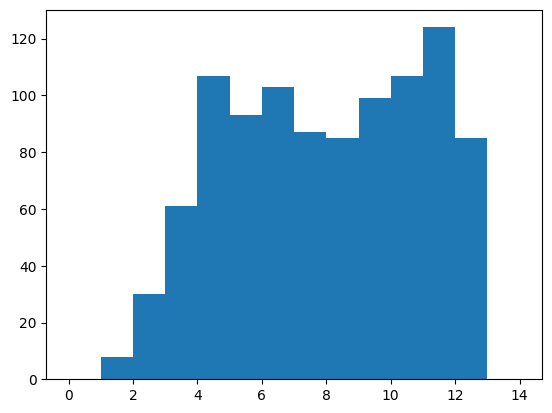

In [9]:
plt.hist(atoms.sum(1), bins=np.arange(0, 15));

In [10]:
def get_pred_points(steps):

    return 10**np.arange(1,7+1/steps,1/steps)
    

In [27]:
class calculate_distance(nn.Module):

    def __init__(self, pred_points):
        super().__init__()

        self.points = torch.tensor(pred_points)[:, None].to('cuda')#torch.tensor(10**np.arange(1,7+6/n_points,6/n_points))[:, None]
        self.n_points = pred_points.shape[0]
        
    def forward(self, p_hat, param_p):
        # add channels dimension
        #param_p_hat = param_p_hat[:,None]

        
        #p_hat = F.interpolate(param_p_hat, self.n_points+1, align_corners=True, mode='linear').squeeze()
        points = self.points.repeat(1, p_hat.shape[0]).to('cuda')
        p = langmuirfreudlich(param_p, points).T

        loss = ((p_hat - p)**2).mean(1)
        return loss


class calculate_distance_points(nn.Module):

    def __init__(self, points):
        super().__init__()

        self.points = torch.tensor(points)[:,None]
        #self.relu = nn.ReLU()
        
    def forward(self, param_p_hat, param_p):
        # add channels dimension
        #param_p_hat = self.relu(param_p_hat)

        points = self.points.repeat(1, param_p_hat.shape[0]).to('cuda')
        p = langmuirfreudlich(param_p, points).T

        loss = ((param_p_hat - p)**2).mean(1)
        return loss
        

        
    

In [28]:
_, testloader, trainloader = get_data_pore(atoms, iso_params, edges, pore, edges_sp, edges_ps, bs=32,random=True, p=1, test_size=0.08,drop_last=True)

Text(0, 0.5, 'Loading (mol/kg)')

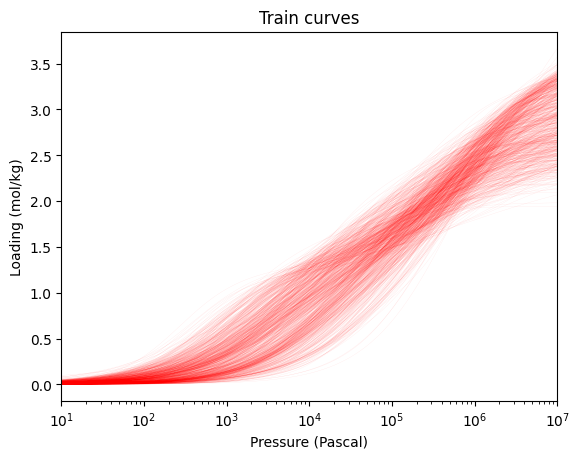

In [29]:
x = 10**np.arange(1,7.01,0.01)
for i in range(len(trainloader.dataset)):
    true_p = langmuirfreudlich(trainloader.dataset.y[[i]].numpy(), x)
    plt.plot(x, true_p, alpha = .1, lw=.2, c='r')
plt.xscale('log')
plt.xlim(10, 1e7)
plt.title('Train curves')
plt.xlabel('Pressure (Pascal)')
plt.ylabel('Loading (mol/kg)')

Text(0, 0.5, 'Loading (mol/kg)')

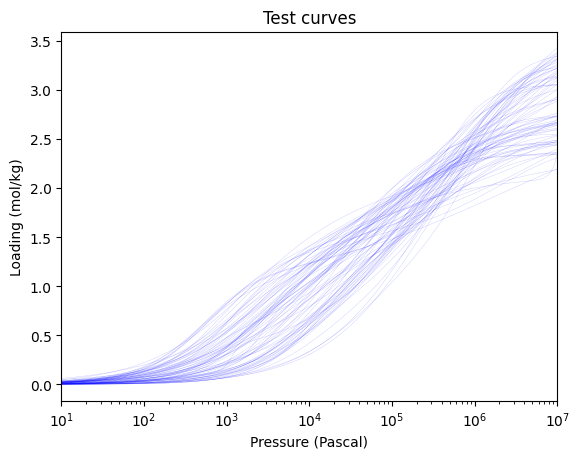

In [30]:
x = 10**np.arange(1,7.01,0.01)
for i in range(len(testloader.dataset)):
    true_p = langmuirfreudlich(testloader.dataset.y[[i]].numpy(), x)
    plt.plot(x, true_p, alpha = .3, lw=.2, c='b')
plt.xscale('log')
plt.xlim(10, 1e7)
plt.title('Test curves')
plt.xlabel('Pressure (Pascal)')
plt.ylabel('Loading (mol/kg)')

In [181]:
pred_points = get_pred_points(5)

In [182]:
baseline_preds = np.zeros((pred_points.shape[0],))
for i in range(len(trainloader.dataset)):
    true_p = langmuirfreudlich(trainloader.dataset.y[[i]].numpy(), pred_points)
    baseline_preds += true_p
baseline_preds /= len(trainloader.dataset)

In [183]:
errors = []
for i in range(len(testloader.dataset)):

    errors.append(calculate_distance(pred_points)(torch.tensor(baseline_preds)[None].cuda(), testloader.dataset.y[[i]].cuda()).item())

In [184]:
print('baseline:', np.mean(errors))

baseline: 0.04976062320702669


Text(0, 0.5, 'Loading (mol/kg)')

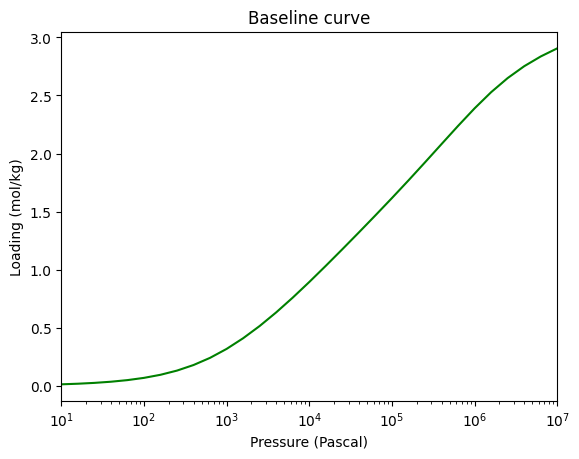

In [185]:
plt.plot(pred_points, baseline_preds, c='g')
plt.xscale('log')
plt.xlim(10, 1e7)
plt.title('Baseline curve')
plt.xlabel('Pressure (Pascal)')
plt.ylabel('Loading (mol/kg)')

In [186]:
len(pred_points)

31

In [187]:
h_size = 12

In [222]:
class PoreLoading(nn.Module):

    def __init__(self, pred_points, out_size=32):
        super().__init__()

        self.pred_points = torch.tensor(pred_points).to('cuda').float()
        self.mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                hid_size=[16]*6, site_emb_size=16, edge_emb_size=16, mlp_size=16,
                centers=12, mx_d=8, width=1, pool='sum', 
                out_size=out_size).to('cuda')

        self.lin_out1 = nn.Sequential(nn.Linear(out_size+1, out_size), nn.LeakyReLU())
        self.lin_out2 = nn.Linear(out_size+1, 1)
        self.relu = nn.LeakyReLU()
            
    
    def forward(self, sites, bonds, sites_p, bonds_sp, bonds_ps, param_p):

        x =  self.relu(self.mpnn(sites, bonds, sites_p, bonds_sp, bonds_ps))[:, None].repeat((1, self.pred_points.shape[0], 1))
        pred_points = 10*torch.log10(self.pred_points[None, :, None].repeat((x.shape[0], 1, 1)))

        x = torch.cat([x, pred_points], -1)
        x = self.lin_out1(x)
        x = torch.cat([x, pred_points], -1)
        x = self.lin_out2(x).squeeze()
        
        return x

        
    def fit(self, trainloader, testloader, epochs, crit=nn.HuberLoss, crit_kwargs={'delta':1}, opt=optim.Adam, opt_kwargs={'lr':0.001}, scale_loss=True):
        
        if scale_loss:
            crit_kwargs['reduction'] = 'none'
        
        # defines optimizer + loss criterion
        self.optimizer = opt(params=self.parameters(), **opt_kwargs)
        self.criterion = crit(**crit_kwargs)
        
        train_loss = []
        test_loss = []
        
        pbar = tqdm(range(epochs), unit='epoch', postfix='loss', position=0, leave=True)
        for e in pbar:
            self.train()
            for idx, (sites, bonds, sites_p, bonds_sp, bonds_ps, y) in enumerate(trainloader):
                
                # model breaks for batch size 1
                if sites.shape[0] == 1:
                    continue
                    
                self.optimizer.zero_grad()
                sites, bonds, sites_p, bonds_sp, bonds_ps, y = sites.float().to('cuda'), bonds.float().to('cuda'), sites_p.float().to('cuda'), bonds_sp.float().to('cuda'), bonds_ps.float().to('cuda'), y.float().to('cuda')
                y_hat = self.forward(sites, bonds, sites_p, bonds_sp, bonds_ps, y)
                y_hat = y_hat.squeeze()
                #y_hat = y_hat.reshape(y_hat.shape[0])
                loss = self.criterion(y_hat, y)
                if scale_loss:
                    loss /= y
                loss = loss.mean()
                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

        
            self.eval()

            for idx, (sites, bonds, sites_p, bonds_sp, bonds_ps, y) in enumerate(testloader):
                
                
                # model breaks for batch size 1
                if sites.shape[0] == 1:
                    continue
                
                with torch.no_grad():
                    sites, bonds, sites_p, bonds_sp, bonds_ps, y = sites.float().to('cuda'), bonds.float().to('cuda'), sites_p.float().to('cuda'), bonds_sp.float().to('cuda'), bonds_ps.float().to('cuda'), y.float().to('cuda')
                    y_hat = self.forward(sites, bonds, sites_p, bonds_sp, bonds_ps, y)
                    y_hat = y_hat.squeeze()
                    # y_hat = y_hat.reshape(y_hat.shape[0])
                    loss = self.criterion(y_hat, y)
                    if scale_loss:
                        loss /= y
                    loss = loss.mean()
                    test_loss.append(loss.item())
            pbar.postfix = f'loss: {np.mean(train_loss[-len(trainloader)+1:]):.3f} test loss: {np.mean(test_loss[-len(testloader)+1:]):.3f}'

        return train_loss, test_loss

In [223]:
mpnn = PoreLoading(pred_points, 32).to('cuda')


In [224]:
len(pred_points)

31

In [225]:
#tr_loss, te_loss = mpnn.fit(trainloader, testloader, epochs=20, crit=calculate_distance_points, crit_kwargs={'points':pred_points}, opt=optim.Adam, opt_kwargs={'lr':0.001}, scale_loss=False)
tr_loss, te_loss = mpnn.fit(trainloader, testloader, epochs=100, crit=calculate_distance, crit_kwargs={'pred_points':pred_points}, opt=optim.Adam, opt_kwargs={'lr':0.001}, scale_loss=False)
#tr_loss, te_loss = mpnn.fit(trainloader, testloader, epochs=20, crit=calculate_distance_sequence, crit_kwargs={'n_points':100, 'h_size':h_size, 'pred_points':pred_points}, opt=optim.Adam, opt_kwargs={'lr':0.001}, scale_loss=False)

100%|███████████████████████████████████████████████| 100/100 [13:48<00:00,  8.29s/epoch, loss: 0.012 test loss: 0.012]


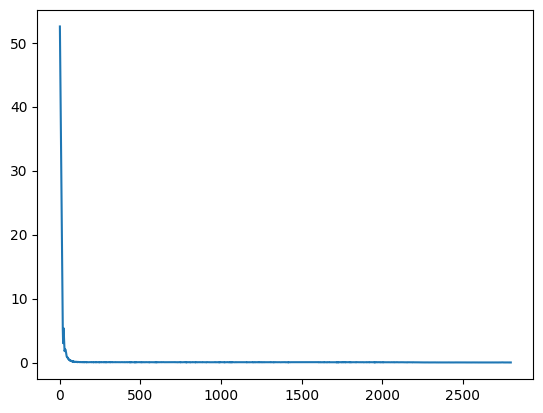

In [226]:
plt.plot(tr_loss)

In [227]:
# def plot_true_pred(mpnn, dataloader, idx, pred_points, fig=None, ax=None, cumsum=False, relu=False):

#     atoms = dataloader.dataset.X[[idx]]
#     iso_params = dataloader.dataset.y[[idx]]
#     atoms = atoms.cuda().float()
#     iso_params = iso_params.numpy()


#     if fig is None:
#         fig, ax = plt.subplots()

#     x = 10**np.arange(1,7.01,0.01)
#     true_p = langmuirfreudlich(iso_params, x)
#     ax.plot(x, true_p)

#     with torch.no_grad():
#         mpnn.eval()
#         p_hat = mpnn.forward(atoms.repeat(2,1,1), edges.cuda()[None].repeat(2,1,1), torch.tensor(pore).cuda().float()[None].repeat(2,1,1), edges_sp.cuda()[None].repeat(2,1,1), edges_ps.cuda()[None].repeat(2,1,1))[0].cpu()
#         if relu:
#             p_hat = nn.ReLU()(p_hat)
        
#         if cumsum:
#             p_hat = p_hat.cumsum(0)
#         #p_hat = nn.Softplus()(p_hat)
#     print(p_hat.diff(2))
#     ax.plot(pred_points, p_hat)
#     ax.set_ylim( 0,4)
#     ax.set_xscale('log')
#     return fig, ax

def plot_true_pred(mpnn, dataloader, idx, pred_points, fig=None, ax=None, cumsum=False, relu=False):

    atoms = dataloader.dataset.X[[idx]]
    iso_params = dataloader.dataset.y[[idx]]
    atoms = atoms.cuda().float()
    iso_params = iso_params.numpy()


    if fig is None:
        fig, ax = plt.subplots()

    x = 10**np.arange(1,7.01,0.01)
    true_p = langmuirfreudlich(iso_params, x)
    ax.plot(x, true_p)

    with torch.no_grad():
        mpnn.eval()
        p_hat = mpnn.forward(atoms.repeat(2,1,1), edges.cuda()[None].repeat(2,1,1), torch.tensor(pore).cuda().float()[None].repeat(2,1,1), edges_sp.cuda()[None].repeat(2,1,1), edges_ps.cuda()[None].repeat(2,1,1), None)[0].cpu()
    print(p_hat)
    ax.plot(pred_points, p_hat)
    ax.set_ylim( 0,4)
    ax.set_xscale('log')
    ax.vlines(pred_points, ymin=0, ymax=4, ls='--', lw=.2)
    return fig, ax

In [228]:
# y_pred = np.zeros((len(testloader.dataset), len(pred_points)))
# for idx, (sites, bonds, sites_p, bonds_sp, bonds_ps, y) in enumerate(testloader):

    
#     mpnn.eval()

#     b = testloader.batch_size
    
#     with torch.no_grad():
#         sites, bonds, sites_p, bonds_sp, bonds_ps, y = sites.float().to('cuda'), bonds.float().to('cuda'), sites_p.float().to('cuda'), bonds_sp.float().to('cuda'), bonds_ps.float().to('cuda'), y.float().to('cuda')
#         y_hat = mpnn.forward(sites, bonds, sites_p, bonds_sp, bonds_ps)
#         y_hat = y_hat.cpu()

#         _b = y_hat.shape[0]


#         y_pred[idx*b:idx*b+_b] = y_hat
#     #y_true[idx*b:idx*b+_b] = y


In [229]:
pred_points

array([1.00000000e+01, 1.58489319e+01, 2.51188643e+01, 3.98107171e+01,
       6.30957344e+01, 1.00000000e+02, 1.58489319e+02, 2.51188643e+02,
       3.98107171e+02, 6.30957344e+02, 1.00000000e+03, 1.58489319e+03,
       2.51188643e+03, 3.98107171e+03, 6.30957344e+03, 1.00000000e+04,
       1.58489319e+04, 2.51188643e+04, 3.98107171e+04, 6.30957344e+04,
       1.00000000e+05, 1.58489319e+05, 2.51188643e+05, 3.98107171e+05,
       6.30957344e+05, 1.00000000e+06, 1.58489319e+06, 2.51188643e+06,
       3.98107171e+06, 6.30957344e+06, 1.00000000e+07])

tensor([-0.0568, -0.0356, -0.0143,  0.0070,  0.0283,  0.0496,  0.0709,  0.0921,
         0.1134,  0.1347,  0.1560,  0.1925,  0.3277,  0.4630,  0.5982,  0.7335,
         0.8864,  1.0711,  1.2645,  1.4606,  1.6567,  1.8529,  2.0490,  2.2451,
         2.4345,  2.6070,  2.7669,  2.9162,  3.0655,  3.1982,  3.3197])


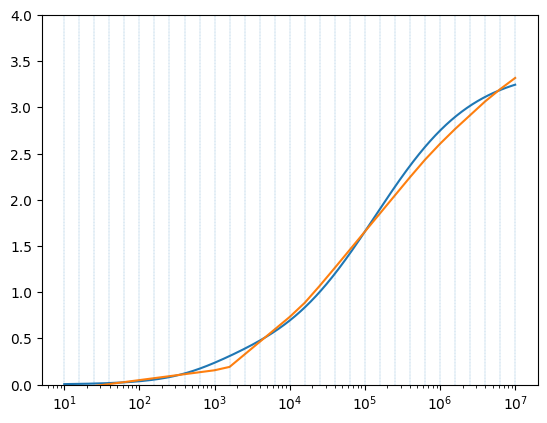

In [230]:
f,a = plot_true_pred(mpnn, testloader, 3, pred_points, cumsum=False, relu=False)

tensor([-0.0083,  0.0130,  0.0343,  0.0556,  0.0768,  0.0981,  0.1194,  0.1407,
         0.1620,  0.2047,  0.3400,  0.4752,  0.6104,  0.7457,  0.8809,  1.0162,
         1.1514,  1.3205,  1.5035,  1.6646,  1.8355,  1.9963,  2.1358,  2.2573,
         2.3789,  2.5004,  2.5873,  2.6721,  2.7569,  2.8418,  2.9266])


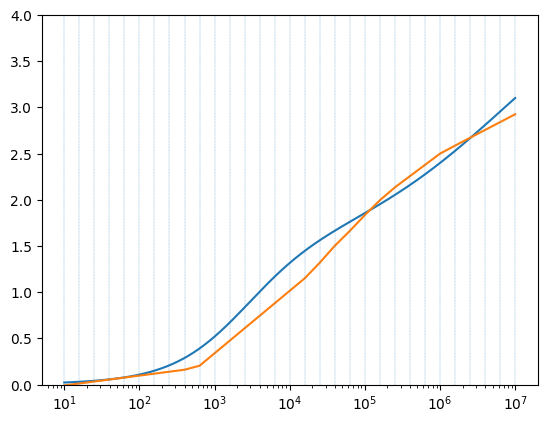

In [231]:
f,a = plot_true_pred(mpnn, testloader, 5, pred_points, cumsum=False, relu=False)

tensor([-0.0594, -0.0381, -0.0168,  0.0044,  0.0257,  0.0470,  0.0683,  0.0896,
         0.1109,  0.1322,  0.1534,  0.1747,  0.2882,  0.4235,  0.5587,  0.6940,
         0.8292,  1.0063,  1.1931,  1.3892,  1.5854,  1.7815,  1.9776,  2.1737,
         2.3699,  2.5477,  2.7194,  2.8703,  3.0196,  3.1684,  3.2899])


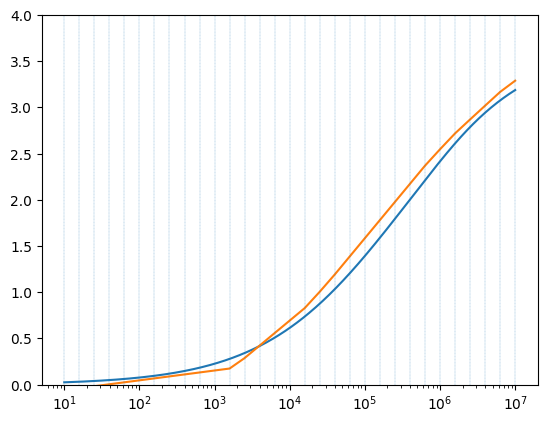

In [232]:
f,a = plot_true_pred(mpnn, testloader, 55, pred_points, cumsum=False, relu=False)

tensor([-4.4590e-02, -2.3305e-02, -2.0201e-03,  1.9265e-02,  4.0550e-02,
         6.1835e-02,  8.3120e-02,  1.0441e-01,  1.2569e-01,  1.4697e-01,
         1.6826e-01,  2.5597e-01,  3.9122e-01,  5.2646e-01,  6.6171e-01,
         7.9696e-01,  9.3258e-01,  1.1173e+00,  1.3029e+00,  1.4990e+00,
         1.6951e+00,  1.8913e+00,  2.0874e+00,  2.2677e+00,  2.4394e+00,
         2.5960e+00,  2.7453e+00,  2.8881e+00,  3.0096e+00,  3.1312e+00,
         3.2282e+00])


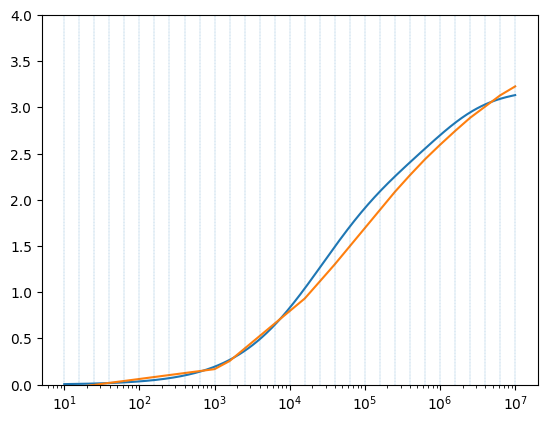

In [233]:
f,a = plot_true_pred(mpnn, testloader, 25, pred_points, cumsum=False, relu=False)

tensor([-0.0996, -0.0783, -0.0570, -0.0357, -0.0144,  0.0069,  0.0281,  0.0494,
         0.0707,  0.0920,  0.1133,  0.1346,  0.1559,  0.1771,  0.2393,  0.3746,
         0.5176,  0.7124,  0.9085,  1.1046,  1.3007,  1.4969,  1.6930,  1.8891,
         2.0853,  2.2814,  2.4775,  2.6737,  2.8698,  3.0659,  3.2620])


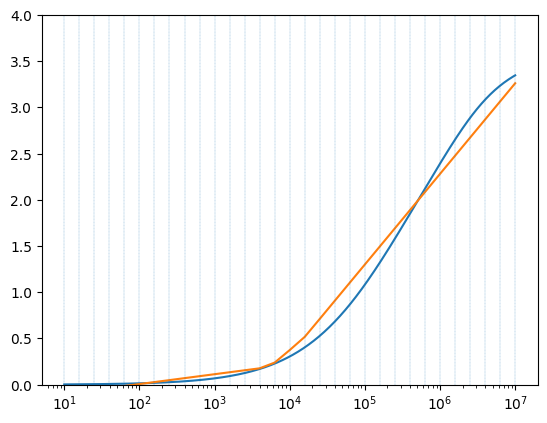

In [234]:
f,a = plot_true_pred(mpnn, testloader, 37, pred_points, cumsum=False, relu=False)

tensor([-0.0048,  0.0184,  0.0416,  0.0648,  0.0881,  0.1113,  0.1345,  0.1577,
         0.1793,  0.2006,  0.3138,  0.4491,  0.5843,  0.7196,  0.8548,  0.9901,
         1.1253,  1.2606,  1.3870,  1.5349,  1.6953,  1.8498,  1.9769,  2.0985,
         2.2200,  2.3416,  2.4378,  2.5226,  2.6075,  2.6923,  2.7772])


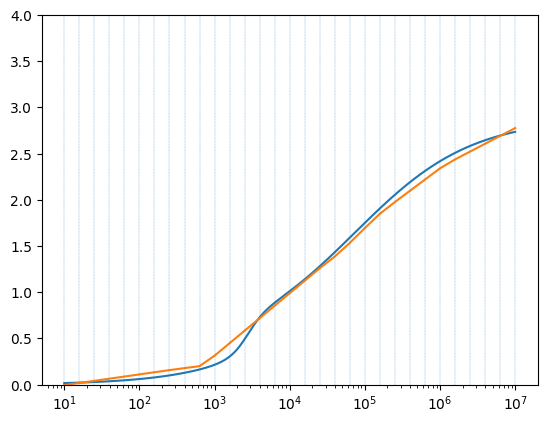

In [235]:
f,a = plot_true_pred(mpnn, testloader, 69, pred_points, cumsum=False, relu=False)